In [10]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas.api.types import is_numeric_dtype
from scipy import stats 
import pickle
import category_encoders
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
import math
import plotly.offline as pyo
import matplotlib.colors as mcolors

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from catboost import CatBoost, Pool
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from lifelines import LogLogisticAFTFitter
from lifelines.utils import concordance_index
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import cumulative_dynamic_auc
import warnings
warnings.filterwarnings("ignore")
import shap
import survshap
from survshap import SurvivalModelExplainer, PredictSurvSHAP, ModelSurvSHAP
shap.initjs()


#Custom Functions
from utilities import model_evaluation
from utilities import survshap_util
import importlib
importlib.reload(model_evaluation)
importlib.reload(survshap_util)

pd.options.display.max_columns = None
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Price Modelling

In [348]:
#Load Price Data
with open('data/price_data.pkl', 'rb') as file:
    df_price = pickle.load(file)
    
X = df_price.drop('LOG_PRICE', axis =1)
y = df_price['LOG_PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
#Utility Variables
num_cols = X_train.select_dtypes(include='number').columns.tolist()
cat_cols = X_train.select_dtypes(include='object').columns.tolist()
cat_features = X_train.columns.get_indexer(X_train.select_dtypes(include = [object, bool]).columns)

numerical_transformer = StandardScaler()
categorical_transformer = TargetEncoder()

In [17]:
#Baseline Linear Regression
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

basline_regression = LinearRegression()

baseline_reg_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('baseline_model', basline_regression)
])

baseline_reg_pipe.fit(X_train, y_train)

model_evaluation.reg_eval(baseline_reg_pipe, X_test, y_test)

MAE: 0.07809978382976247
MSE: 0.009797763309444206
RMSE: 0.09898365172817279
Adj_R2: 0.8864379035321591


In [24]:
#Tree Based Models
rf_reg = RandomForestRegressor(random_state = 42)
lgb_reg = LGBMRegressor(random_state = 42)
cat_reg = CatBoostRegressor(random_state = 42, verbose = False, cat_features=cat_features)

tree_preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols), #No numerical transformations required
        ('cat', categorical_transformer, cat_cols)
    ])

rf_pipeline = Pipeline(steps=[
    ('preprocessor', tree_preprocessor),
    ('regressor', rf_reg)
])

lgb_pipeline = Pipeline(steps=[
    ('preprocessor', tree_preprocessor),
    ('regressor', lgb_reg)
])

cat_pipeline = Pipeline(steps=[
    ('preprocessor', None), #No preprocessing required for catboost
    ('regressor', cat_reg)
])

#Tuning
rf_param_space = {
    'regressor__n_estimators': Integer(50, 1000),
    'regressor__max_depth': Integer(2, 20),
    'regressor__min_samples_leaf': Integer(1,4),
    'regressor__min_samples_split': Integer(2,10)
}

lgb_param_space = {
    'regressor__n_estimators': Integer(50, 1000),
    'regressor__max_depth': Integer(2, 20),
    'regressor__learning_rate': Real(0.01, 3.0, 'log-uniform'),
    'regressor__num_leaves': Integer(20,1000),
    'regressor__bagging_fraction': Real (0.1, 1.0, 'uniform')
}

cat_param_space = {
    'regressor__max_depth': Integer(2, 12),
    'regressor__learning_rate': Real(0.01, 3.0, 'log-uniform'),
    'regressor__iterations': Integer(50, 1000),
}

rf_search = BayesSearchCV(rf_pipeline, rf_param_space, scoring = 'neg_root_mean_squared_error' , random_state = 42,
                          cv=5, n_iter=20, n_jobs = -1)
rf_search.fit(X_train, y_train)
print('RF')
print('best params:', rf_search.best_params_)
model_evaluation.reg_eval(rf_search, X_test, y_test)
print('------------------------------')

lgb_search = BayesSearchCV(lgb_pipeline, lgb_param_space, scoring = 'neg_root_mean_squared_error', random_state = 42,
                           cv=5, n_iter=20, n_jobs = -1)
lgb_search.fit(X_train, y_train)
print('LGB')
print('best params:', lgb_search.best_params_)
model_evaluation.reg_eval(lgb_search, X_test, y_test)
print('------------------------------')

cat_search = BayesSearchCV(cat_pipeline, cat_param_space, scoring = 'neg_root_mean_squared_error', random_state = 42,
                           cv=5, n_iter=20, n_jobs = -1)
cat_search.fit(X_train, y_train)
print('CAT')
print('best params:', cat_search.best_params_)
model_evaluation.reg_eval(cat_search, X_test, y_test)

RF
best params: OrderedDict([('regressor__max_depth', 16), ('regressor__min_samples_leaf', 1), ('regressor__min_samples_split', 10), ('regressor__n_estimators', 1000)])
MAE: 0.0605163584475977
MSE: 0.006222262555897629
RMSE: 0.07888131943557758
Adj_R2: 0.9278801540408753
------------------------------
[LightGBM] [Warning] bagging_fraction is set=0.4702338029811567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4702338029811567
LGB
best params: OrderedDict([('regressor__bagging_fraction', 0.4702338029811567), ('regressor__learning_rate', 0.04833423832656882), ('regressor__max_depth', 17), ('regressor__n_estimators', 234), ('regressor__num_leaves', 555)])
MAE: 0.06005125493005053
MSE: 0.006082436465401557
RMSE: 0.07798997669830116
Adj_R2: 0.9295008243383838
------------------------------
CAT
best params: OrderedDict([('regressor__iterations', 841), ('regressor__learning_rate', 0.07619172647171589), ('regressor__max_depth', 9)])
MAE: 0.061352524678191724
MSE: 0.00628017

In [349]:
# SHAP for catboost model
best_params = {key.replace('regressor__', ''): value for key, value in cat_search.best_params_.items()}
best_params = OrderedDict(best_params.items())

cat_model = CatBoostRegressor(random_state = 42, 
                              cat_features=cat_features, 
                              verbose = False,
                              **best_params)

cat_model.fit(X_train, y_train)

explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_train)

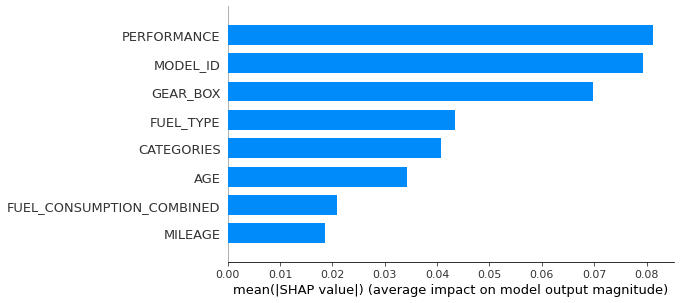

In [350]:
shap.summary_plot(shap_values, X_train, plot_type="bar", show = False)
plt.savefig("plots/price_avg_feature_impact.png",dpi=1000, bbox_inches = "tight")
plt.show()

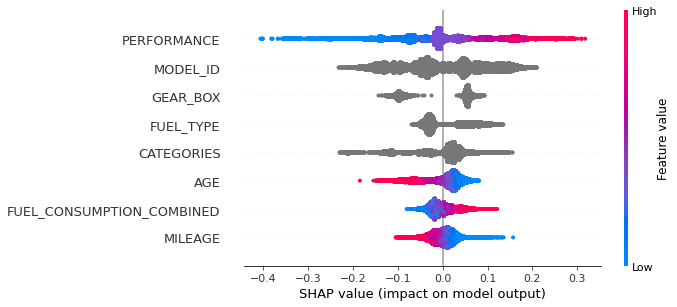

In [351]:
shap.summary_plot(shap_values, X_train, show = False)
plt.savefig("plots/price_feat_value_impact.png",dpi=1000, bbox_inches = "tight")
plt.show()

In [113]:
#Fit model on whole dataset
price_model = cat_model.fit(X, y)

# Survival Modelling

### DOP estimation and data preperation

In [354]:
#Load Target Data
with open('data/target_data.pickle', 'rb') as file:
    target_data = pickle.load(file)

In [355]:
#Apply Predictions for Market Value and DOP estimation
target_data['MARKET_VALUE'] = price_model.predict(target_data)
target_data['MARKET_VALUE'] = target_data['MARKET_VALUE'].apply(lambda x: round(math.exp(x)))
target_data['DOP'] = (target_data['PRICE']/target_data['MARKET_VALUE']).round(2)


In [356]:
#Preprocessing
target_data = target_data.drop(['PRICE', 'MARKET_VALUE', 'MODEL_ID', 'GEAR_BOX', 
                                'MILEAGE', 'FUEL_CONSUMPTION_COMBINED'], axis = 1)

#Replace 0 day durations with 1 day
target_data.loc[target_data['TIME_TO_EVENT'] == 0, 'TIME_TO_EVENT'] = 1

object_cols = target_data.select_dtypes(include=['object']).columns
    
## One Hot encoding and Category Masking    
for col in object_cols:
    # Replace category types with numbered labels
    types = target_data[col].unique()
    type_mapping = {types: f"type{i}" for i, types in enumerate(types)}
    target_data[col] = target_data[col].replace(type_mapping)
    
    counts = target_data[col].value_counts(normalize=True)
    mask = counts < 0.01
    others = counts[mask].index.tolist()
        
    target_data[col] = target_data[col].apply(lambda x: "other" if x in others else x)
        
    one_hot_encoded = pd.get_dummies(target_data[col], prefix=col)

    target_data = pd.concat([target_data, one_hot_encoded], axis=1)
    target_data.drop(col, axis=1, inplace=True)
    
with open('data/survival_data.pickle', 'wb') as d:
    pickle.dump(target_data, d)

### Baseline AFT

In [2]:
with open('data/survival_data.pickle', 'rb') as file:
    surv_df = pickle.load(file)

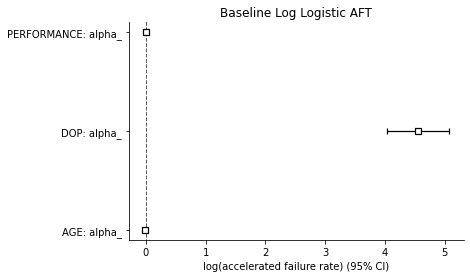

In [359]:
#Interpretation
baseline_aft = LogLogisticAFTFitter()
baseline_aft.fit(surv_df, duration_col='TIME_TO_EVENT', event_col='EVENT')

# Get significant variables from summary
summary = baseline_aft.summary
significant_vars = summary[summary['p'] < 0.05]

#Plot coefficients of significant variables except intercept
ax = baseline_aft.plot(columns = [name[1] for name in significant_vars.index.tolist()[:-1]])
ax.set_title('Baseline Log Logistic AFT')
plt.savefig('plots/baseline_aft.png', dpi=1000, bbox_inches = "tight")
plt.show()

In [518]:
#Prediction and model evaluation
aft_train, aft_test = train_test_split(surv_df, test_size=0.30, random_state=420)

##Fit
baseline_aft = LogLogisticAFTFitter()
baseline_aft.fit(aft_train, 'TIME_TO_EVENT', 'EVENT')

##Evaluate
predictions = baseline_aft.predict_median(aft_test)
score = concordance_index(aft_test['TIME_TO_EVENT'], predictions, aft_test['EVENT'])
print("Concordance Index Score: ", score)

Concordance Index Score:  0.743558605402151


### Survival Catboost 

In [521]:
#Original feature set
no_dop_df = target_data.copy()
surv_catboost_no_dop = surv_catboost(no_dop_df)

Train set. Concordance index:0.70684
Val set. Concordance index:0.67568
Test set. Concordance index:0.69240


In [522]:
#Reduced Feature set with DOP
with_dop_df = surv_df.copy()
surv_catboost_with_dop, dop_df_train, feats = surv_catboost(with_dop_df)

Train set. Concordance index:0.74822
Val set. Concordance index:0.71105
Test set. Concordance index:0.73156


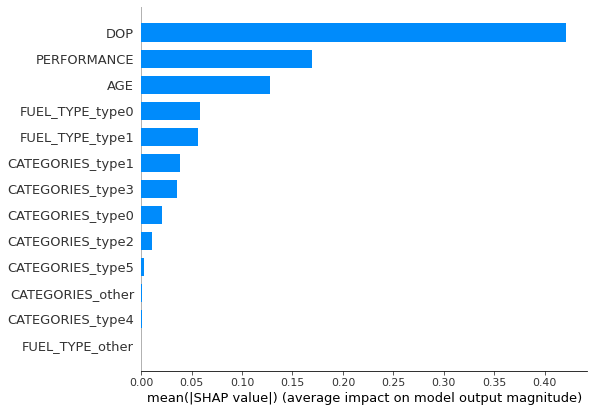

In [523]:
cat_surv_explainer = shap.TreeExplainer(surv_catboost_with_dop)
cat_surv_shap_values = cat_surv_explainer.shap_values(dop_df_train[feats])

shap.summary_plot(cat_surv_shap_values, dop_df_train[feats], plot_type="bar", show = False)
plt.savefig("plots/cat_surv_avg_impact.png",dpi=1000, bbox_inches = "tight")
plt.show()

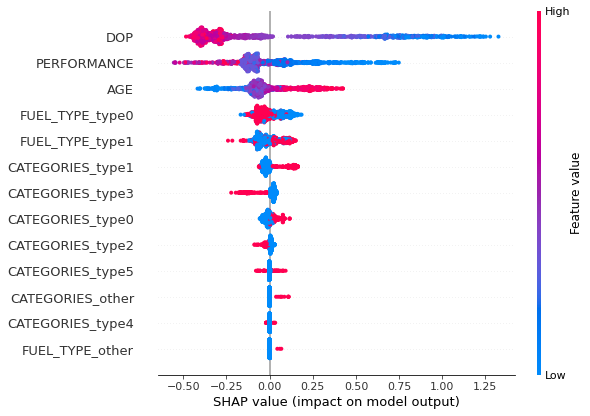

In [524]:
shap.summary_plot(cat_surv_shap_values, dop_df_train[feats], show = False)
plt.savefig("plots/cat_surv_shap_values.png",dpi=1000, bbox_inches = "tight")
plt.show()

### Scikit-Surv Application

#### Random Survival Forest

In [501]:
X = surv_df.drop(['EVENT', 'TIME_TO_EVENT'], axis = 1)
y = surv_df[['EVENT', 'TIME_TO_EVENT']].to_records(index=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=420)

#Hyperparamter Tuning
param_dist = {"n_estimators": Integer(50, 1000),
              "max_depth": Integer(2,20),
              "min_samples_leaf": Integer(2, 20),
              "min_samples_split": Integer(2, 20)}

rsf_search = BayesSearchCV(RandomSurvivalForest(random_state = 42, n_jobs = -1), 
                           search_spaces=param_dist, cv=5, n_iter=50, n_jobs=-1)
rsf_search.fit(X_train, y_train)

print(rsf_search.best_params_)

OrderedDict([('max_depth', 11), ('min_samples_leaf', 5), ('min_samples_split', 12), ('n_estimators', 635)])


In [502]:
#Fit and Save
rsf = RandomSurvivalForest(random_state = 42, 
                           n_jobs = -1,
                           **rsf_search.best_params_)

rsf.fit(X_train, y_train)

In [503]:
rsf.score(X_test, y_test)

0.7651918393037958

#### Survival Gradient Boosting

In [510]:
param_dist = {"n_estimators": Integer(50, 1000),
              "max_depth": Integer(2,20),
              "learning_rate": Real(0.01, 1.0, prior='log-uniform'),
              "min_samples_leaf": Integer(2, 20),
              "min_samples_split": Integer(2, 20),
              "subsample": Real(0.1, 1.0, prior='uniform'),
              "dropout_rate": Real(0.0, 0.5, prior='uniform')}

sgb_search = BayesSearchCV(GradientBoostingSurvivalAnalysis(random_state = 42), 
                           search_spaces=param_dist, cv=5, n_iter=50, n_jobs=-1)
sgb_search.fit(X_train, y_train)

print(sgb_search.best_params_)

OrderedDict([('dropout_rate', 0.1420069965492887), ('learning_rate', 1.0), ('max_depth', 7), ('min_samples_leaf', 2), ('min_samples_split', 20), ('n_estimators', 1000), ('subsample', 0.41288784310945736)])


In [511]:
sgb = GradientBoostingSurvivalAnalysis(random_state = 42, 
                                       **sgb_search.best_params_)

sgb.fit(X_train, y_train)

In [512]:
sgb.score(X_test, y_test)

0.7645008346788539

#### Time dependent AUC

In [513]:
#Get Risk Scores for every week
days = np.arange(7, 280, 7)

rsf_chf_funcs = rsf.predict_cumulative_hazard_function(X_test, return_array=False)
rsf_risk_scores = np.row_stack([chf(days) for chf in rsf_chf_funcs])

sgb_chf_funcs = sgb.predict_cumulative_hazard_function(X_test, return_array=False)
sgb_risk_scores = np.row_stack([chf(days) for chf in sgb_chf_funcs])

rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(y_train, y_test, rsf_risk_scores, days)
sgb_auc, sgb_mean_auc = cumulative_dynamic_auc(y_train, y_test, sgb_risk_scores, days)

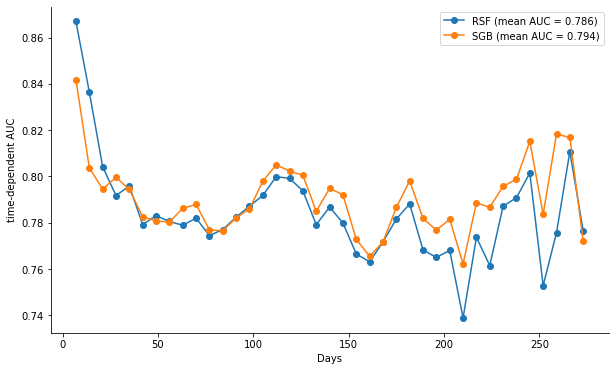

In [516]:
#Plot 
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(days, rsf_auc, "o-", label="RSF (mean AUC = {:.3f})".format(rsf_mean_auc))
ax.plot(days, sgb_auc, "o-", label="SGB (mean AUC = {:.3f})".format(sgb_mean_auc))
ax.set_xlabel("Days")
ax.set_ylabel("time-dependent AUC")
ax.legend(loc="upper right")
ax.grid(False)

plt.savefig('plots/rsf_sgb_auc.png', transparent=True)

# Analysis

### SurvShap

In [14]:
#Prepare data with significant features only
X = surv_df[['DOP', 'AGE', 'PERFORMANCE']]
y = surv_df[['EVENT', 'TIME_TO_EVENT']].to_records(index=False)

#Train best Survival Model on whole data
best_surv_params = rsf_search.best_params_

surv_model = RandomSurvivalForest(random_state = 42,
                                 n_jobs=-1,
                                 **best_surv_params)

surv_model.fit(X,y)
surv_model.score(X,y)

0.8069348449089683

In [526]:
#Create explanations
model_exp = SurvivalModelExplainer(surv_model, X, y)

global_rsf_exp = ModelSurvSHAP(random_state=42)
global_rsf_exp.fit(model_exp)

100%|██████████| 2733/2733 [5:34:20<00:00,  7.34s/it]  


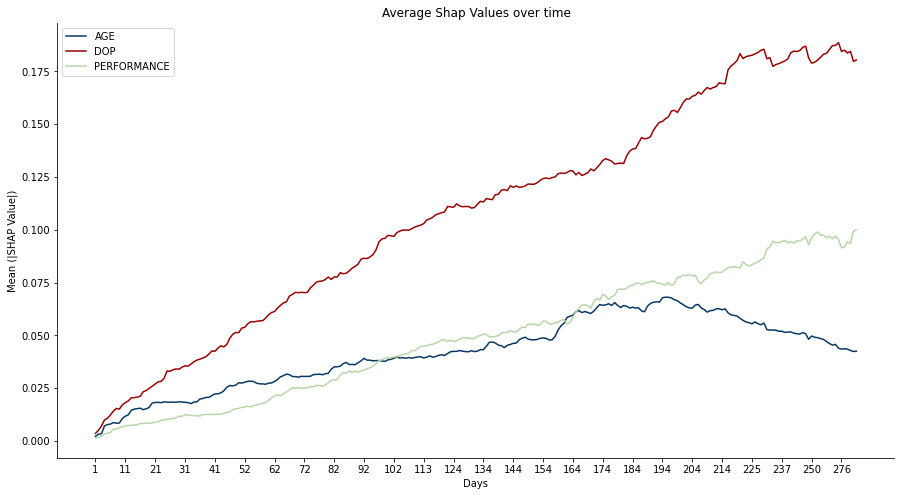

In [7]:
#Extract Global Results in DataFrame
global_results = global_rsf_exp.result

#Prepapre time columns for plot
global_results = survshap_util.time_processing(global_results)

#Plot Results
fig, ax = plt.subplots(figsize=(15, 8))
custom_colors = ['#073763', '#990000', '#b6d7a8']
for i, (name, group) in enumerate(global_results.groupby('variable_name')):
    x = global_results.columns[5:] #Retreive all time based columns 
    y = group[x].values.tolist()[0]
    ax.plot(x, y, label=name, color = custom_colors[i % len(custom_colors)])

ax.set_title('Average Shap Values over time')
ax.set_xlabel('Days')
ax.set_xticks(x[::10])
ax.set_ylabel('Mean (|SHAP Value|)')
ax.legend()

plt.savefig('plots/mean_shap(t).png', transparent=True)

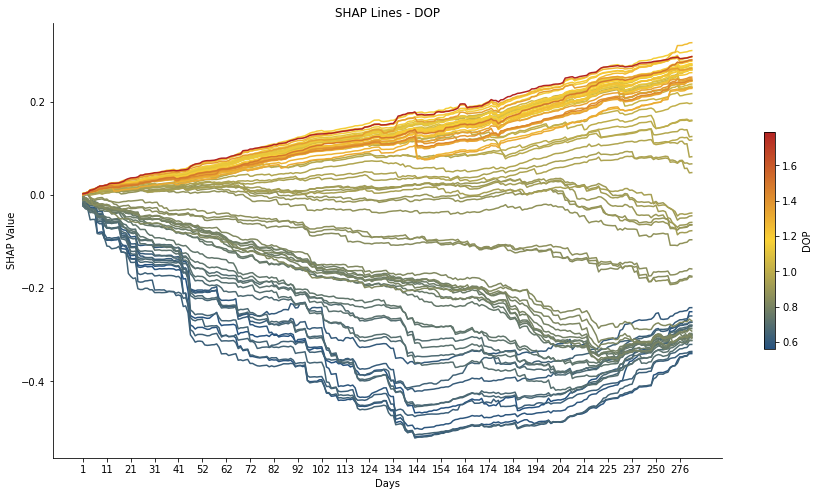

In [11]:
#Plot SHAP lines for DOP
full_global = global_rsf_exp.full_result
survshap_util.shap_lines_plot(full_global, 'DOP')
plt.savefig('plots/dop_shap(t).png', transparent=True)

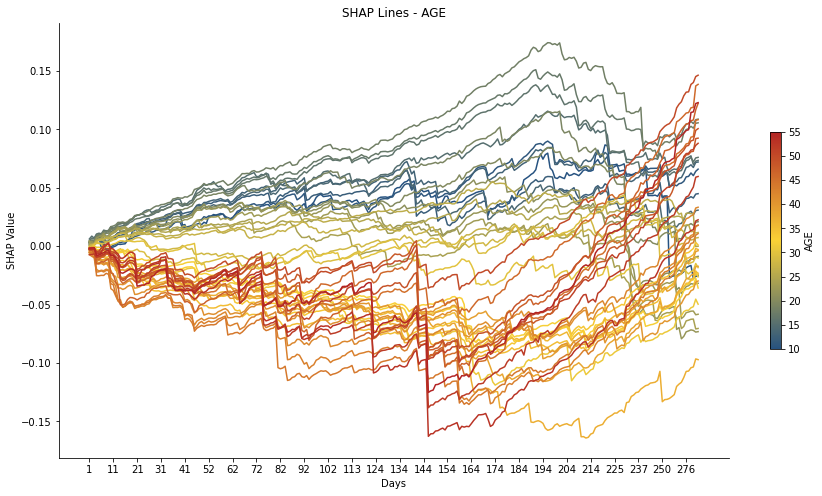

In [12]:
#Plot SHAP lines for AGE
survshap_util.shap_lines_plot(full_global, 'AGE')
plt.savefig('plots/age_shap(t).png', transparent=True)

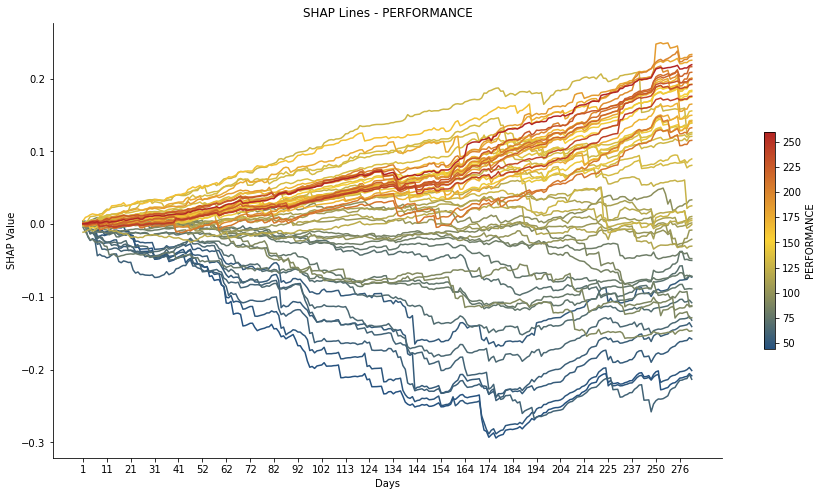

In [13]:
#Plot SHAP lines for PERFORMANCE
survshap_util.shap_lines_plot(full_global, 'PERFORMANCE')
plt.savefig('plots/perf_shap(t).png', transparent=True)

### Survival Function

In [15]:
#Get Survival Probabilities over time for each listing
ids =  surv_df.index.tolist()
surv_prob = surv_model.predict_survival_function(X)

data = {'id': [], 'day': [], 'surv_prob': []}


for i, (surv_prob, id) in enumerate(zip(surv_prob, ids)):
    data['id'].extend([id] * len(surv_prob.x))
    data['day'].extend(surv_prob.x)
    data['surv_prob'].extend(surv_prob.y)

surv_prob_df = pd.DataFrame(data)

#Add DOP Quartiles
dop_vals = surv_df[['DOP']]
surv_prob_df = surv_prob_df.merge(dop_vals, left_on='id', right_index=True, how='left')
surv_prob_df['DOP_Quartile'] = pd.qcut(surv_prob_df['DOP'], q=[0, 0.25, 0.5, 0.75, 1.0], 
                                       labels=['DOP-Q1', 'DOP-Q2', 'DOP-Q3', 'DOP-Q4'])

#Aggregated Data for analysis
grouped_df = surv_prob_df.groupby(['DOP_Quartile', 'day'])['surv_prob'].agg(np.mean).reset_index()

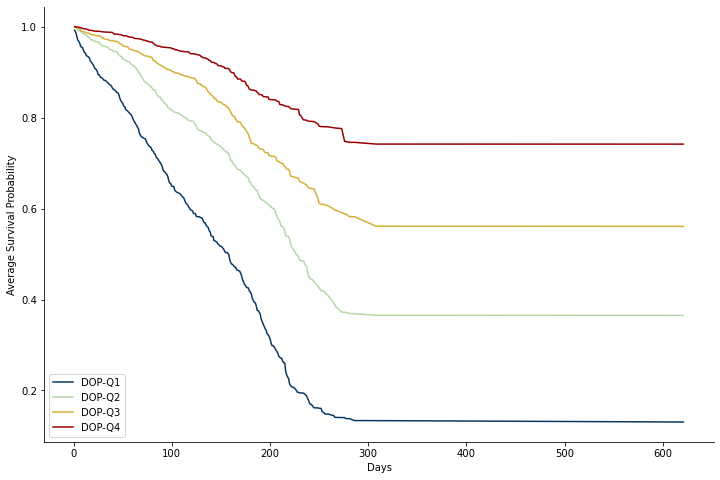

In [16]:
custom_colors = ['#073763', '#b6d7a8', '#d4af37', '#990000']

# plot the data with a separate line for each DOP_Quantile
fig, ax = plt.subplots(figsize=(12,8))
for i,group in enumerate(grouped_df['DOP_Quartile'].unique()):
    ax.plot('day', 'surv_prob', 
            data=grouped_df[grouped_df['DOP_Quartile']==group], 
            label=group, 
            color=custom_colors[i])
    
ax.set_xlabel('Days')
ax.set_ylabel('Average Survival Probability')
ax.legend(loc='lower left')
plt.savefig('plots/survival_function.png', transparent=True)

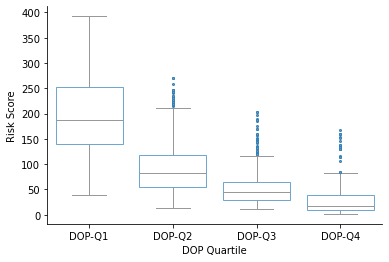

In [17]:
surv_scores = surv_model.predict(X)
risk_data = surv_df.copy()
risk_data["risk_scores"] = surv_scores

risk_data['DOP_Quartile'] = pd.qcut(risk_data['DOP'], q=[0, 0.25, 0.5, 0.75, 1.0], 
                                       labels=['DOP-Q1', 'DOP-Q2', 'DOP-Q3', 'DOP-Q4'])

#risk_summary = risk_data.groupby(['DOP_Quartile'])['risk_scores'].agg(np.mean).reset_index()
sns.boxplot(x="DOP_Quartile", y="risk_scores", data=risk_data,
            color="white", linewidth=1, 
            boxprops=dict(alpha=.7, edgecolor=["#3182bd"][0]),
            flierprops=dict(markeredgecolor=["#3182bd"][0], marker='o', markersize=2))

plt.xlabel("DOP Quartile")
plt.ylabel("Risk Score")
plt.savefig('plots/risk_scores.png', transparent=True)